<a href="https://colab.research.google.com/github/f-has/mimic4obesityreproduction/blob/main/Statistical_Analysis_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reproduction of Severity of Illness Scores May Misclassify Critically Ill Obese Patients: Main Statistical Analysis

## Setup

We need to:

1. Import libraries.
2. Authenticate with Google.
3. Set the `project-id` which will be used for billing query costs. Query costs for this tutorial are typically ~0.01 - 0.05 USD.

In [40]:
!pip install -U -q pandas-profiling==3.0.0 pandas pyyaml==5.4.1 MarkupSafe==2.0.1
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [41]:
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# You only need to authenticate once per session.
auth.authenticate_user()

# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf


# below imports are used for pretty pandas dataframes and plots
from IPython.display import display, HTML
%matplotlib inline
plt.style.use('ggplot')


from sklearn.model_selection import train_test_split


from  sklearn import linear_model

from sklearn.linear_model import LinearRegression
from scipy.stats.distributions import chi2

from pandas_profiling import ProfileReport

# Set up environment variables
project_id = 'final-project-2022-354718'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
    return pd.io.gbq.read_gbq(
        query,
        project_id=project_id,
        dialect="standard"
    )
if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project at the top of this cell.')

# test it works
df = run_query("""
SELECT *
FROM `final-project-2022-354718.Obs.final_cohort`
""")
assert df.shape[0] >= 1, 'unable to query MIMIC!'
display(df.head())


,subject_id,hadm_id,stay_id,admittime,exclude_non_adult,exclude_readmission,exclude_lab_result,exclude_weight,exclude_height,exclude_bmi,bmi_group,bmi
0,17583589,28926250,34684932,2184-05-31 07:45:00,0,0,0,0,0,0,0,20.126385
1,10242302,25476687,39647285,2155-01-08 03:44:00,0,0,0,0,0,0,0,20.342798
2,18453450,24676167,38623255,2171-12-13 08:10:00,0,0,0,0,0,0,0,21.152344
3,19024087,23464962,34448487,2121-11-26 00:00:00,0,0,0,0,0,0,0,24.980469
4,15248565,26705577,38910085,2116-11-02 00:00:00,0,0,0,0,0,0,0,24.980469


Load datasets from google query.


In [42]:
#Pull tables from google cloud

print('\n'.join(['='*20, 'Final cohort normal', '='*20]))

coh_fin_norm = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.final_cohort`
WHERE bmi_group=0
order by stay_id
''')
display(coh_fin_norm.head())

print('\n'.join(['='*20, 'Final cohort obese', '='*20]))

coh_fin_obese = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.final_cohort`
WHERE bmi_group=1
order by stay_id
''')
display(coh_fin_obese.head())

print('\n'.join(['='*20, 'baseline demographics normal', '='*20]))

baseline_dem_norm = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.baseline_demographics`
WHERE bmi_group=0
order by stay_id
''')
display(baseline_dem_norm.head())


print('\n'.join(['='*20, 'baseline demographics obese', '='*20]))

baseline_dem_obese = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.baseline_demographics`
WHERE bmi_group=1
order by stay_id
''')
display(baseline_dem_obese.head())


print('\n'.join(['='*20, 'ICU lab results normal', '='*20]))

ICU_lab_results_norm = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.lab_results_first_day`
WHERE bmi_group=0
order by stay_id
''')
display(ICU_lab_results_norm.head())


print('\n'.join(['='*20, 'ICU lab results obese', '='*20]))

ICU_lab_results_obese = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.lab_results_first_day`
WHERE bmi_group=1
order by stay_id
''')
display(ICU_lab_results_obese.head())



print('\n'.join(['='*20, 'baseline lab results normal', '='*20]))

baseline_lab_results_norm = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.lab_results_baseline`
WHERE bmi_group=0
order by stay_id
''')
display(baseline_lab_results_norm.head())


print('\n'.join(['='*20, ' baseline lab results obese', '='*20]))

baseline_lab_results_obese = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.lab_results_baseline`
WHERE bmi_group=1
order by stay_id
''')
display(baseline_lab_results_obese.head())



print('\n'.join(['='*20, 'Mechanical ventilation normal', '='*20]))

mechanical_vent_first_day_norm = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.mechanical_vent_first_day`
WHERE bmi_group=0
order by stay_id
''')
display(mechanical_vent_first_day_norm.head())


print('\n'.join(['='*20, ' Mechanical ventilation obese', '='*20]))

mechanical_vent_first_day_obese = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.mechanical_vent_first_day`
WHERE bmi_group=1
order by stay_id
''')
display(mechanical_vent_first_day_obese.head())




print('\n'.join(['='*20, 'Renal replacement therapy normal', '='*20]))

rrt_first_day_norm = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.rrt_first_day`
WHERE bmi_group=0
order by stay_id
''')
display(rrt_first_day_norm.head())


print('\n'.join(['='*20, ' Renal replacement therapy obese', '='*20]))

rrt_first_day_obese= run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.rrt_first_day`
WHERE bmi_group=1
order by stay_id
''')
display(rrt_first_day_obese.head())




print('\n'.join(['='*20, 'vasopressors normal', '='*20]))

vasopressors_first_day_norm = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.vasopressors_first_day`
WHERE bmi_group=0
order by stay_id
''')
display(vasopressors_first_day_norm.head())


print('\n'.join(['='*20, ' vasopressors obese', '='*20]))

vasopressors_first_day_obese= run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.vasopressors_first_day`
WHERE bmi_group=1
order by stay_id
''')
display(vasopressors_first_day_obese.head())


print('\n'.join(['='*20, ' severity score normal', '='*20]))

severity_score_norm = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.severity_score`
WHERE bmi_group=0
order by stay_id
''')
display(severity_score_norm.head())


print('\n'.join(['='*20, ' severity score obese', '='*20]))

severity_score_obese= run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.severity_score`
WHERE bmi_group=1
order by stay_id
''')
display(severity_score_obese.head())



print('\n'.join(['='*20, ' ICD Diagnosis norm', '='*20]))


ICD_diagnosis_norm=run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.ICD9and10` 
WHERE bmi_group=0
''')

display(ICD_diagnosis_norm.head())

print('\n'.join(['='*20, ' ICD Diagnosis norm', '='*20]))



ICD_diagnosis_obese=run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.ICD9and10` 
WHERE bmi_group=1
''')

display(ICD_diagnosis_obese.head())

print('\n'.join(['='*20, ' ICD Diagnosis obese', '='*20]))











Final cohort normal


,subject_id,hadm_id,stay_id,admittime,exclude_non_adult,exclude_readmission,exclude_lab_result,exclude_weight,exclude_height,exclude_bmi,bmi_group,bmi
0,14036785,25517749,30008105,2146-10-29 00:00:00,0,0,0,0,0,0,0,23.287037
1,11317133,20143910,30016009,2129-09-21 07:15:00,0,0,0,0,0,0,0,22.837370
2,16782996,29432324,30047249,2158-04-01 07:15:00,0,0,0,0,0,0,0,20.390625
3,15956706,26653641,30117047,2121-05-25 13:17:00,0,0,0,0,0,0,0,24.326531
4,15983568,27344395,30128855,2173-01-02 01:08:00,0,0,0,0,0,0,0,18.958150


Final cohort obese


,subject_id,hadm_id,stay_id,admittime,exclude_non_adult,exclude_readmission,exclude_lab_result,exclude_weight,exclude_height,exclude_bmi,bmi_group,bmi
0,17907707,24556282,30068359,2111-06-14 00:00:00,0,0,0,0,0,0,1,34.178145
1,13073338,23159892,30076188,2174-10-25 00:00:00,0,0,0,0,0,0,1,31.958617
2,17924767,25031760,30091276,2170-08-05 07:30:00,0,0,0,0,0,0,1,30.636926
3,16748556,27998771,30093379,2136-11-16 01:06:00,0,0,0,0,0,0,1,38.992282
4,17650020,22362982,30108158,2140-12-26 11:45:00,0,0,0,0,0,0,1,34.220408


baseline demographics normal


,subject_id,hadm_id,stay_id,admittime,exclude_non_adult,exclude_readmission,exclude_lab_result,exclude_weight,exclude_height,exclude_bmi,...,ethnicity,admittime_1,dischtime,hospital_expire_flag,marital_status_fin,insurance_fin,admission_type_fin,source_of_admission_fin,icu_adm_type_fin,charlson_comorbidity_index
0,14036785,25517749,30008105,2146-10-29 00:00:00,0,0,0,0,0,0,...,WHITE,2146-10-29 00:00:00,2146-11-02 17:56:00,0,Married,Medicare/Medicaid,Other,Physician referral,Cardiac surgery recovery unit,4
1,11317133,20143910,30016009,2129-09-21 07:15:00,0,0,0,0,0,0,...,UNKNOWN,2129-09-21 07:15:00,2129-09-27 13:40:00,0,other/unknown,Private/Other,Other,Physician referral,Cardiac surgery recovery unit,8
2,16782996,29432324,30047249,2158-04-01 07:15:00,0,0,0,0,0,0,...,WHITE,2158-04-01 07:15:00,2158-04-09 15:00:00,0,Married,Private/Other,Other,Physician referral,Surgical ICU/trauma ICU/coronary care unit,1
3,16782996,29432324,30047249,2158-04-01 07:15:00,0,0,0,0,0,0,...,WHITE,2158-04-01 07:15:00,2158-04-09 15:00:00,0,Married,Private/Other,Other,Physician referral,Surgical ICU/trauma ICU/coronary care unit,1
4,15956706,26653641,30117047,2121-05-25 13:17:00,0,0,0,0,0,0,...,WHITE,2121-05-25 13:17:00,2121-06-01 17:30:00,0,other/unknown,Medicare/Medicaid,Emergency,Physician referral,Cardiac surgery recovery unit,7


baseline demographics obese


,subject_id,hadm_id,stay_id,admittime,exclude_non_adult,exclude_readmission,exclude_lab_result,exclude_weight,exclude_height,exclude_bmi,...,ethnicity,admittime_1,dischtime,hospital_expire_flag,marital_status_fin,insurance_fin,admission_type_fin,source_of_admission_fin,icu_adm_type_fin,charlson_comorbidity_index
0,17907707,24556282,30068359,2111-06-14 00:00:00,0,0,0,0,0,0,...,WHITE,2111-06-14 00:00:00,2111-06-23 19:03:00,0,Married,Private/Other,Other,Physician referral,Cardiac surgery recovery unit,3
1,13073338,23159892,30076188,2174-10-25 00:00:00,0,0,0,0,0,0,...,WHITE,2174-10-25 00:00:00,2174-10-31 17:40:00,0,Married,Private/Other,Other,Physician referral,Cardiac surgery recovery unit,8
2,17924767,25031760,30091276,2170-08-05 07:30:00,0,0,0,0,0,0,...,OTHER,2170-08-05 07:30:00,2170-08-08 13:45:00,0,Married,Private/Other,Elective,Physician referral,Cardiac surgery recovery unit,2
3,16748556,27998771,30093379,2136-11-16 01:06:00,0,0,0,0,0,0,...,WHITE,2136-11-16 01:06:00,2136-11-20 14:45:00,0,Married,Private/Other,Other,Physician referral,Cardiac surgery recovery unit,1
4,17650020,22362982,30108158,2140-12-26 11:45:00,0,0,0,0,0,0,...,WHITE,2140-12-26 11:45:00,2141-01-01 18:00:00,0,Married,Private/Other,Other,Physician referral,Cardiac surgery recovery unit,5


ICU lab results normal


,stay_id,bmi_group,icu_wbc,icu_platelets,icu_NA,icu_k,icu_BUN,icu_Cr,icu_BIC
0,30008105,0,13.3,162.0,136.0,4.6,9.0,0.7,23.0
1,30016009,0,9.3,143.0,143.0,4.3,26.0,1.0,24.0
2,30047249,0,6.0,150.0,142.0,4.5,17.0,0.6,33.0
3,30117047,0,13.6,143.0,136.0,4.9,17.0,1.0,22.0
4,30128855,0,20.6,379.0,148.0,4.2,28.0,0.8,24.0


ICU lab results obese


,stay_id,bmi_group,icu_wbc,icu_platelets,icu_NA,icu_k,icu_BUN,icu_Cr,icu_BIC
0,30068359,1,22.7,154.0,137.0,4.3,12.0,0.9,20.0
1,30076188,1,20.3,116.0,141.0,4.2,14.0,1.4,23.0
2,30091276,1,14.5,260.0,141.0,4.2,13.0,0.9,26.0
3,30093379,1,13.2,150.0,137.0,4.3,16.0,0.7,23.0
4,30108158,1,20.5,250.0,140.0,4.4,20.0,1.0,22.0


baseline lab results normal


,stay_id,subject_id,bmi_group,avgwbc_baseline,avgsodium_baseline,avgpotassium_baseline,avgbun_baseline,avgbic_baseline,avgcreatinine_baseline,avgplatelets_baseline
0,30008105,14036785,0,5.000000,138.000000,4.200000,8.000000,29.000000,0.700000,277.000000
1,30016009,11317133,0,4.400000,140.000000,4.900000,27.000000,26.000000,1.400000,293.000000
2,30047249,16782996,0,3.400000,NaN,NaN,NaN,NaN,NaN,178.000000
3,30117047,15956706,0,7.500000,140.000000,4.700000,23.000000,28.000000,1.200000,222.000000
4,30128855,15983568,0,9.945205,136.430556,4.238356,19.465753,24.957746,0.998649,316.383562


 baseline lab results obese


,stay_id,subject_id,bmi_group,avgwbc_baseline,avgsodium_baseline,avgpotassium_baseline,avgbun_baseline,avgbic_baseline,avgcreatinine_baseline,avgplatelets_baseline
0,30068359,17907707,1,10.60,140.0,4.70,14.0,25.0,1.00,311.0
1,30076188,13073338,1,7.70,141.0,4.00,16.0,27.5,1.25,193.0
2,30091276,17924767,1,7.85,141.0,4.00,17.0,25.5,1.05,289.5
3,30093379,16748556,1,6.05,139.0,3.70,19.0,25.0,0.90,184.0
4,30108158,17650020,1,8.50,137.0,4.65,25.5,24.0,1.15,238.5


Mechanical ventilation normal


,stay_id,bmi_group,mech_vent
0,NaN,0,N
1,NaN,0,N
2,NaN,0,N
3,NaN,0,N
4,NaN,0,N


 Mechanical ventilation obese


,stay_id,bmi_group,mech_vent
0,NaN,1,N
1,NaN,1,N
2,NaN,1,N
3,NaN,1,N
4,NaN,1,N


Renal replacement therapy normal


,stay_id,bmi_group,rrt
0,30008105,0,N
1,30016009,0,N
2,30047249,0,N
3,30117047,0,N
4,30128855,0,N


 Renal replacement therapy obese


,stay_id,bmi_group,rrt
0,30068359,1,N
1,30076188,1,N
2,30091276,1,N
3,30093379,1,N
4,30108158,1,N


vasopressors normal


,stay_id,max_start,bmi_group,vassopressor
0,30008105,NaT,0,N
1,30016009,2129-09-22 09:51:00,0,Y
2,30047249,NaT,0,N
3,30117047,2121-05-26 13:00:00,0,Y
4,30128855,NaT,0,N


 vasopressors obese


,stay_id,max_start,bmi_group,vassopressor
0,30068359,2111-06-15 06:55:00,1,Y
1,30076188,2174-10-26 08:46:00,1,Y
2,30091276,NaT,1,N
3,30093379,2136-11-16 17:00:00,1,Y
4,30108158,2140-12-27 08:59:00,1,Y


 severity score normal


,stay_id,sapsii_score,sofa_score,bmi_group
0,30008105,28.0,2.826087,0
1,30016009,39.0,4.241758,0
2,30047249,24.0,1.705882,0
3,30117047,40.0,4.973913,0
4,30128855,70.0,5.113971,0


 severity score obese


,stay_id,sapsii_score,sofa_score,bmi_group
0,30068359,37.0,4.768116,1
1,30076188,40.0,4.439024,1
2,30091276,20.0,3.476190,1
3,30093379,21.0,2.739130,1
4,30108158,39.0,2.464789,1


 ICD Diagnosis norm


,subject_id,hadm_id,bmi_group,icd_code,icd_version,long_title,ICD_diagnosis
0,14659520,23014255,0,486,9,"Pneumonia, organism unspecified","Sepsis, including pneumonia"
1,10701372,26886489,0,486,9,"Pneumonia, organism unspecified","Sepsis, including pneumonia"
2,10739214,28714064,0,0380,9,Streptococcal septicemia,Other
3,16511971,20208013,0,0389,9,Unspecified septicemia,Other
4,10280129,21648590,0,0389,9,Unspecified septicemia,Other


 ICD Diagnosis norm


,subject_id,hadm_id,bmi_group,icd_code,icd_version,long_title,ICD_diagnosis
0,13326608,27231862,1,452,9,Portal vein thrombosis,Other
1,11639652,27934774,1,486,9,"Pneumonia, organism unspecified","Sepsis, including pneumonia"
2,17613792,21634194,1,570,9,Acute and subacute necrosis of liver,Other
3,15683445,22528346,1,C61,10,Malignant neoplasm of prostate,Other
4,10271044,25590216,1,G92,10,Toxic encephalopathy,Other


 ICD Diagnosis obese


Statistical analysis:  T-Test for Continuous Demographic values with 
means and Mann Whitney for median  

In [43]:
##Mann Whitney Test 
age_wilcox=stats.mannwhitneyu(baseline_dem_norm['age'], baseline_dem_obese['age'])[1]
comorbidity_wilcox=stats.mannwhitneyu(baseline_dem_norm['charlson_comorbidity_index'], baseline_dem_obese['charlson_comorbidity_index'])[1]
BMI_wilcox= stats.mannwhitneyu(baseline_dem_norm['bmi'], baseline_dem_obese['bmi'])[1]
SAPS_wilcox=stats.mannwhitneyu(severity_score_norm['sapsii_score'], severity_score_obese['sapsii_score'])[1]
#drop NA 
severity_score_norm.dropna(subset=['sofa_score'],inplace=True)
severity_score_obese.dropna(subset=['sofa_score'],inplace=True)


##T-Test 
SOFA_wilcox=stats.mannwhitneyu(severity_score_norm['sofa_score'], severity_score_obese['sofa_score'])[-1]
#generate table
pd.DataFrame([[age_wilcox,comorbidity_wilcox,BMI_wilcox,SAPS_wilcox,SOFA_wilcox]],columns=['age_wilcox','comorbidity_wilcox','BMI_wilcox','SAPS_wilcox','SOFA_t_test'])
                              



,age_wilcox,comorbidity_wilcox,BMI_wilcox,SAPS_wilcox,SOFA_t_test
0,0.000004,0.525481,1.489768e-185,0.413674,0.000029


Chi square test to test statistical association between categorical variables



  1. gender, 2. ethnicity,3. Marital Status,4. Insurance, smoker, 6. Admission type,Source of Admission, ICU type,  Primary diagnosis, Mechanical ventilation first 24h, 11. Vasopressors in the first 24h, 13. renal replacement Therapy in the first 24h





In [44]:
#gender p-value
contigency_gen= pd.crosstab(baseline_dem_norm['gender'], baseline_dem_obese['gender']) 
pval_gen=chi2_contingency(contigency_gen)[1]

#ethnicity p-value
contigency_eth= pd.crosstab(baseline_dem_norm['ethnicity'], baseline_dem_obese['ethnicity']) 
pval_eth=chi2_contingency(contigency_eth)[1]

#Marital Status p-value
contigency_mart= pd.crosstab(baseline_dem_norm['marital_status_fin'], baseline_dem_obese['marital_status_fin']) 
pval_mart=chi2_contingency(contigency_mart)[1]

#Insurance p-value
contigency_insurance= pd.crosstab(baseline_dem_norm['insurance_fin'], baseline_dem_obese['insurance_fin']) 
pval_insurance=chi2_contingency(contigency_insurance)[1]


##smoker##


#Admission type p-value
contigency_adm_type= pd.crosstab(baseline_dem_norm['admission_type_fin'], baseline_dem_obese['admission_type_fin']) 
pval_adm_type=chi2_contingency(contigency_adm_type)[1]

#Source of admission type p-value
contigency_source_adm= pd.crosstab(baseline_dem_norm['source_of_admission_fin'], baseline_dem_obese['source_of_admission_fin']) 
pval_source_adm=chi2_contingency(contigency_source_adm)[1]

##Primary diagnosis##


#ICU admission type
contigency_ICU_adm= pd.crosstab(baseline_dem_norm['icu_adm_type_fin'], baseline_dem_obese['icu_adm_type_fin']) 
pval_ICU_adm=chi2_contingency(contigency_ICU_adm)[1]

#Renal replacement therapy
contigency_rrt= pd.crosstab(rrt_first_day_norm['rrt'], rrt_first_day_obese['rrt']) 
pval_rrt=chi2_contingency(contigency_rrt)[1]

#Mechanical ventilation therapy 

contigency_mech_vent= pd.crosstab(mechanical_vent_first_day_norm['mech_vent'], mechanical_vent_first_day_obese['mech_vent']) 
pval_mech_vent=chi2_contingency(contigency_mech_vent)[1]


#Vassopressors therapy 

contigency_vass= pd.crosstab(vasopressors_first_day_norm['vassopressor'], vasopressors_first_day_obese['vassopressor']) 
pval_vass=chi2_contingency(contigency_vass)[1]

#ICD diagnosis: 

contigency_icd= pd.crosstab(ICD_diagnosis_norm['ICD_diagnosis'], ICD_diagnosis_obese['ICD_diagnosis']) 
pval_icd=chi2_contingency(contigency_icd)[1]



pval_tab=pd.DataFrame([[pval_gen,pval_eth,pval_mart,pval_insurance,pval_adm_type,
                        pval_source_adm,pval_ICU_adm,pval_rrt,pval_mech_vent,pval_vass,pval_icd]],columns=['pval_gen','pval_eth','pval_mart','pval_insurance','pval_adm_type',
                        'pval_source_adm','pval_ICU_adm','pval_rrt','pval_mech_vent','pval_vass','pval_icd'])
                              

pval_tab




,pval_gen,pval_eth,pval_mart,pval_insurance,pval_adm_type,pval_source_adm,pval_ICU_adm,pval_rrt,pval_mech_vent,pval_vass,pval_icd
0,0.225258,0.851794,0.686807,0.408536,0.620398,0.89845,0.96468,1.0,5.270222e-21,0.426509,1.343108e-15


calculate statistical signifcance table 2:

In [45]:
#Baseline laboratory study
# extract columns take median, and calculate percentiles concatenate to get IQR
#for normal population
s1= baseline_lab_results_norm.iloc[:,3:10].median()
s2_1=baseline_lab_results_norm.iloc[:,3:10].quantile(0.25)
s2_2=baseline_lab_results_norm.iloc[:,3:10].quantile(0.75)
s2_3= pd.concat([s1,s2_1, s2_2], axis=1).reset_index()
s2_3['IQR']=s2_3[0.25].astype(str) + '-' + s2_3[0.75].astype(str)
s2_3 = s2_3.iloc[:,[1,4]]

#for obese population

s3= baseline_lab_results_obese.iloc[:,3:10].median()
s4_1=baseline_lab_results_obese.iloc[:,3:10].quantile(0.25)
s4_2=baseline_lab_results_obese.iloc[:,3:10].quantile(0.75)
s4_3= pd.concat([s3,s4_1, s4_2], axis=1).reset_index()
s4_3['IQR']=s4_3[0.25].astype(str) + '-' + s4_3[0.75].astype(str)
s4_3=s4_3.iloc[:,[1,4]]

# Join both populations, obese and 
final_baseline=pd.concat([s2_3, s4_3], axis=1).reset_index()
final_baseline=final_baseline.iloc[:,-4:]


#rename index

final_baseline.rename(index={0:'WBC',1:'sodium',2:'potassium',3:'BUN',4:'BIC',5:'creatinine',6:'platelets'},inplace=True)


#rename columns: 

final_baseline.columns = ['base_med_norm', 'base_IQR_norm', 'base_med_obese', 'base_IQR_obese']
final_baseline



,base_med_norm,base_IQR_norm,base_med_obese,base_IQR_obese
WBC,6.6,5.5-8.275,7.200000,6.0-8.7
sodium,139.0,137.0-141.0,140.000000,138.0-141.0
potassium,4.2,4.0-4.5,4.200000,4.0-4.5
BUN,17.0,14.0-22.0,18.000000,15.0-23.0
BIC,27.0,25.0-29.0,26.000000,24.0-28.0
creatinine,0.9,0.8-1.1,0.929167,0.8-1.1
platelets,222.0,183.5-270.54545454545456,213.625000,175.5-257.0


Mann-Whitney Test for association for laboratory baseline values

In [46]:
#Mann-Whitney Test for association for laboratory baseline values
#drop NA 
baseline_lab_results_norm.dropna(subset=['avgwbc_baseline'],inplace=True)
baseline_lab_results_obese.dropna(subset=['avgwbc_baseline'],inplace=True)
baseline_lab_results_norm.dropna(subset=['avgsodium_baseline'],inplace=True)
baseline_lab_results_obese.dropna(subset=['avgsodium_baseline'],inplace=True)
baseline_lab_results_norm.dropna(subset=['avgpotassium_baseline'],inplace=True)
baseline_lab_results_obese.dropna(subset=['avgpotassium_baseline'],inplace=True)
baseline_lab_results_norm.dropna(subset=['avgbun_baseline'],inplace=True)
baseline_lab_results_obese.dropna(subset=['avgbun_baseline'],inplace=True)
baseline_lab_results_norm.dropna(subset=['avgbic_baseline'],inplace=True)
baseline_lab_results_obese.dropna(subset=['avgbic_baseline'],inplace=True)
baseline_lab_results_norm.dropna(subset=['avgcreatinine_baseline'],inplace=True)
baseline_lab_results_obese.dropna(subset=['avgcreatinine_baseline'],inplace=True)
baseline_lab_results_norm.dropna(subset=['avgplatelets_baseline'],inplace=True)
baseline_lab_results_obese.dropna(subset=['avgplatelets_baseline'],inplace=True)




wbc= stats.mannwhitneyu(baseline_lab_results_norm['avgwbc_baseline'], baseline_lab_results_obese['avgwbc_baseline'])[1]
na_p=stats.mannwhitneyu(baseline_lab_results_norm['avgsodium_baseline'], baseline_lab_results_obese['avgsodium_baseline'])[1]
k_p=stats.mannwhitneyu(baseline_lab_results_norm['avgpotassium_baseline'], baseline_lab_results_obese['avgpotassium_baseline'])[1]
bun_p= stats.mannwhitneyu(baseline_lab_results_norm['avgbun_baseline'], baseline_lab_results_obese['avgbun_baseline'])[1]
bic_p=stats.mannwhitneyu(baseline_lab_results_norm['avgbic_baseline'], baseline_lab_results_obese['avgbic_baseline'])[1]
cr_p=stats.mannwhitneyu(baseline_lab_results_norm['avgcreatinine_baseline'], baseline_lab_results_obese['avgcreatinine_baseline'])[1]
plate_p=stats.mannwhitneyu(baseline_lab_results_norm['avgplatelets_baseline'], baseline_lab_results_obese['avgplatelets_baseline'])[1]




pval_tab=pd.DataFrame([[wbc, na_p, k_p,bun_p, 
                        bic_p, cr_p, plate_p]],columns=['wbc', 'na_p', 'k_p','bun_p', 
                       ' bic_p', 'cr_p', 'plate_p'])
                             
pval_tab

,wbc,na_p,k_p,bun_p,bic_p,cr_p,plate_p
0,0.000035,0.19153,0.969162,0.018847,0.000002,0.046624,0.025057


In [47]:
##normal population
dev_merge_norm = ICU_lab_results_norm.merge(baseline_lab_results_norm, how='left', on='stay_id')
#calculate differences
dev_merge_norm['diff_wbc'] = dev_merge_norm['icu_wbc'] - dev_merge_norm['avgwbc_baseline']
dev_merge_norm['diff_sodium'] = dev_merge_norm['icu_NA'] - dev_merge_norm['avgsodium_baseline']
dev_merge_norm['diff_potassium'] = dev_merge_norm['icu_k'] - dev_merge_norm['avgpotassium_baseline']
dev_merge_norm['diff_BUN'] = dev_merge_norm['icu_BUN'] - dev_merge_norm['avgbun_baseline']
dev_merge_norm['diff_BIC'] = dev_merge_norm['icu_BIC'] - dev_merge_norm['avgbic_baseline']
dev_merge_norm['diff_platelets'] = dev_merge_norm['icu_platelets'] - dev_merge_norm['avgplatelets_baseline']
dev_merge_norm['diff_creatinine'] = dev_merge_norm['icu_Cr'] - dev_merge_norm['avgcreatinine_baseline']


norm_dev=dev_merge_norm.iloc[:,-7:]
norm_dev.head()


##obese population
dev_merge_obese = ICU_lab_results_obese.merge(baseline_lab_results_obese, how='left', on='stay_id')
#calculate differences
dev_merge_obese['diff_wbc'] = dev_merge_obese['icu_wbc'] - dev_merge_obese['avgwbc_baseline']
dev_merge_obese['diff_sodium'] = dev_merge_obese['icu_NA'] - dev_merge_obese['avgsodium_baseline']
dev_merge_obese['diff_potassium'] = dev_merge_obese['icu_k'] - dev_merge_obese['avgpotassium_baseline']
dev_merge_obese['diff_BUN'] = dev_merge_obese['icu_BUN'] - dev_merge_obese['avgbun_baseline']
dev_merge_obese['diff_BIC'] = dev_merge_obese['icu_BIC'] - dev_merge_obese['avgbic_baseline']
dev_merge_obese['diff_platelets'] = dev_merge_obese['icu_platelets'] - dev_merge_obese['avgplatelets_baseline']
dev_merge_obese['diff_creatinine'] = dev_merge_obese['icu_Cr'] - dev_merge_obese['avgcreatinine_baseline']


obese_dev=dev_merge_obese.iloc[:,-7:]
obese_dev.head()

,diff_wbc,diff_sodium,diff_potassium,diff_BUN,diff_BIC,diff_platelets,diff_creatinine
0,12.10,-3.0,-0.40,-2.0,-5.0,-157.0,-0.10
1,12.60,0.0,0.20,-2.0,-4.5,-77.0,0.15
2,6.65,0.0,0.20,-4.0,0.5,-29.5,-0.15
3,7.15,-2.0,0.60,-3.0,-2.0,-34.0,-0.20
4,12.00,3.0,-0.25,-5.5,-2.0,11.5,-0.15


In [48]:

#ICU- Baseline laboratory results

                
s1=norm_dev.mean()
s2=np.std(norm_dev)
s3=obese_dev.mean()
s4=np.std(obese_dev)

ICU_base_dev= pd.concat([s1,s2,s3,s4], axis=1).reset_index()
ICU_base_dev.columns=['Variable','diff normal mean', 'diff normal std', 'diff obese mean', 'diff obese std']

ICU_base_dev

,Variable,diff normal mean,diff normal std,diff obese mean,diff obese std
0,diff_wbc,7.804010,6.062566,8.906339,5.535178
1,diff_sodium,0.361640,3.627234,0.157731,3.400659
2,diff_potassium,0.258565,0.616456,0.384800,0.578276
3,diff_BUN,-0.527822,9.383232,-0.355263,7.839955
4,diff_BIC,-2.524926,3.340850,-1.895310,2.966964
5,diff_platelets,-51.744526,64.125657,-35.042312,50.953732
6,diff_creatinine,-0.023212,0.439639,0.067539,0.450020


In [49]:
#Unadjusted Statistical anlysis of the deviation
#generate wilxcox



#remove NA for normal
norm_dev.dropna(subset=['diff_wbc'],inplace=True)

norm_dev.dropna(subset=['diff_sodium'],inplace=True)

norm_dev.dropna(subset=['diff_potassium'],inplace=True)

norm_dev.dropna(subset=['diff_BUN'],inplace=True)

norm_dev.dropna(subset=['diff_BIC'],inplace=True)

norm_dev.dropna(subset=['diff_platelets'],inplace=True)

norm_dev.dropna(subset=['diff_creatinine'],inplace=True)



## Remove NA  for obese
obese_dev.dropna(subset=['diff_wbc'],inplace=True)

obese_dev.dropna(subset=['diff_sodium'],inplace=True)

obese_dev.dropna(subset=['diff_potassium'],inplace=True)

obese_dev.dropna(subset=['diff_BUN'],inplace=True)

obese_dev.dropna(subset=['diff_BIC'],inplace=True)

obese_dev.dropna(subset=['diff_platelets'],inplace=True)

obese_dev.dropna(subset=['diff_creatinine'],inplace=True)




### run T-Test
pval_WBC_dev=stats.ttest_ind(a=norm_dev['diff_wbc'], b=obese_dev['diff_wbc'])[1]

pval_NA_dev=stats.ttest_ind(a=norm_dev['diff_sodium'], b=obese_dev['diff_sodium'])[1]

pval_K_dev=stats.ttest_ind(a=norm_dev['diff_potassium'], b=obese_dev['diff_potassium'])[1]
  
pval_BUN_dev=stats.ttest_ind(a=norm_dev['diff_BUN'], b=obese_dev['diff_BUN'])[1]
       

pval_BIC_dev=stats.ttest_ind(a=norm_dev['diff_BIC'], b=obese_dev['diff_BIC'])[1]

pval_platelets_dev=stats.ttest_ind(a=norm_dev['diff_platelets'], b=obese_dev['diff_platelets'])[1]


pval_Cr_dev=stats.ttest_ind(a=norm_dev['diff_creatinine'], b=obese_dev['diff_creatinine'])[1]




pval_tab2=pd.DataFrame([[pval_WBC_dev, pval_NA_dev, pval_K_dev, pval_BUN_dev, 
                        pval_BIC_dev, pval_platelets_dev, pval_Cr_dev]],columns=['pval_WBC_dev', 'pval_NA_dev', 'pval_K_dev', 'pval_BUN_dev', 
                        'pval_BIC_dev', 'pval_platelets_dev', 'pval_Cr_dev'])
                              

pval_tab2

,pval_WBC_dev,pval_NA_dev,pval_K_dev,pval_BUN_dev,pval_BIC_dev,pval_platelets_dev,pval_Cr_dev
0,0.00307,0.327253,0.000833,0.673354,0.002457,0.000006,0.00165


Take logarithim of creatinine and BUN as they are the most skewed variables

Text(0.5, 1.0, 'log ICU - baseline BUN Obese')

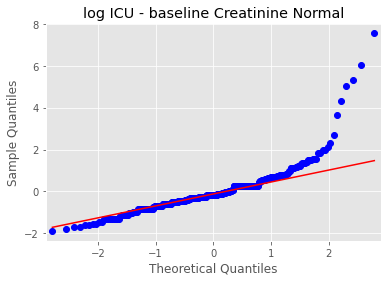

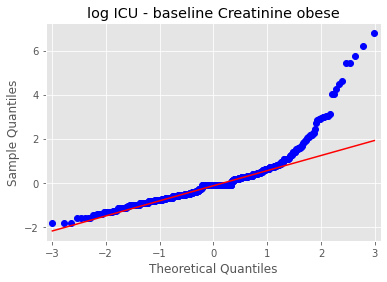

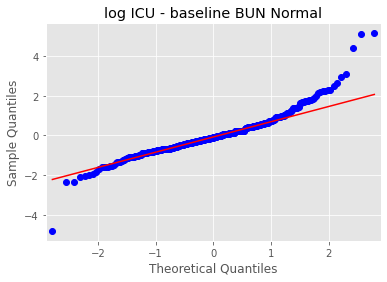

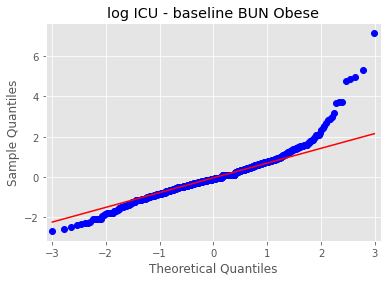

In [50]:
#calculate deviation of obese and normal creatinine of log values

dev_merge_norm['log_diff_creatinine']=np.log10(dev_merge_norm['icu_Cr']) - np.log10(dev_merge_norm['avgcreatinine_baseline'])
dev_merge_obese['log_diff_creatinine']=np.log10(dev_merge_obese['icu_Cr']) - np.log10(dev_merge_obese['avgcreatinine_baseline'])

#calculate deviation of obese and normal BUN of log values
dev_merge_norm['log_diff_BUN'] = np.log10(dev_merge_norm['icu_BUN']) - np.log10(dev_merge_norm['avgbun_baseline'])
dev_merge_obese['log_diff_BUN'] = np.log10(dev_merge_obese['icu_BUN']) - np.log10(dev_merge_obese['avgbun_baseline'])



sm.qqplot(dev_merge_norm['log_diff_creatinine'][np.isfinite(dev_merge_norm['log_diff_creatinine'])], line='q',fit = True)
plt.title('log ICU - baseline Creatinine Normal')


sm.qqplot(dev_merge_obese['log_diff_creatinine'][np.isfinite(dev_merge_obese['log_diff_creatinine'])], line='q',fit = True)
plt.title('log ICU - baseline Creatinine obese')


sm.qqplot(dev_merge_norm['log_diff_BUN'][np.isfinite(dev_merge_norm['log_diff_BUN'])], line='q',fit = True)
plt.title('log ICU - baseline BUN Normal')


sm.qqplot(dev_merge_obese['log_diff_BUN'][np.isfinite(dev_merge_obese['log_diff_BUN'])], line='q',fit = True)
plt.title('log ICU - baseline BUN Obese')


Run T-test on log(creatinine) and  log(BUN)




In [51]:
#drop NA
dev_merge_norm2=dev_merge_norm
dev_merge_obese2=dev_merge_obese

dev_merge_norm2.dropna(subset=['log_diff_creatinine'],inplace=True)
dev_merge_obese2.dropna(subset=['log_diff_creatinine'],inplace=True)


dev_merge_norm2.dropna(subset=['log_diff_BUN'],inplace=True)
dev_merge_obese2.dropna(subset=['log_diff_BUN'],inplace=True)


#Creatinine 

pval_log_Cr_dev=stats.ttest_ind(a=dev_merge_norm2['log_diff_creatinine'], b=dev_merge_obese2['log_diff_creatinine'])[1]
pval_log_BUN_dev=stats.ttest_ind(a=dev_merge_norm2['log_diff_BUN'], b=dev_merge_obese2['log_diff_BUN'])[1]
       

pval_tab3=pd.DataFrame([[ pval_log_BUN_dev, pval_log_Cr_dev]],columns=['pval_log_BUN_dev', 'pval_log_Cr_dev'])
pval_tab3

,pval_log_BUN_dev,pval_log_Cr_dev
0,0.024614,1.230746e-08


In [52]:
# normal log_BUN mean and stdev
log_BUN_mean_norm=dev_merge_norm['log_diff_BUN'].mean()
log_BUN_std_norm= np.std(dev_merge_norm['log_diff_BUN'])

# Obese log_BUN mean and stdev
log_BUN_mean_obese=dev_merge_obese['log_diff_BUN'].mean()
log_BUN_std_obese= np.std(dev_merge_obese['log_diff_BUN'])



# normal log_Cr mean and stdev
log_Cr_mean_norm=dev_merge_norm['log_diff_creatinine'].mean()
log_Cr_std_norm= np.std(dev_merge_norm['log_diff_creatinine'])

# Obese log_Cr mean and stdev
log_Cr_mean_obese=dev_merge_obese['log_diff_creatinine'].mean()
log_Cr_std_obese=np.std(dev_merge_obese['log_diff_creatinine'])




log_dev=pd.DataFrame([[ log_BUN_mean_norm,log_BUN_std_norm,log_BUN_mean_obese,log_BUN_std_obese,
                         log_Cr_mean_norm,log_Cr_std_norm,log_Cr_mean_obese,log_Cr_std_obese]],
                      columns=['log_BUN_mean_norm','log_BUN_std_norm','log_BUN_mean_obese','log_BUN_std_obese',
                         'log_Cr_mean_norm','log_Cr_std_norm','log_Cr_mean_obese','log_Cr_std_obese'])


#log_dev= pd.concat([log_BUN_mean_norm,log_BUN_std_norm,log_BUN_mean_obese,log_BUN_std_obese,
                         #log_Cr_mean_norm,log_Cr_std_norm,log_Cr_mean_obese,log_Cr_std_obese], axis=1).reset_index()

log_dev

,log_BUN_mean_norm,log_BUN_std_norm,log_BUN_mean_obese,log_BUN_std_obese,log_Cr_mean_norm,log_Cr_std_norm,log_Cr_mean_obese,log_Cr_std_obese
0,-0.037806,0.153706,-0.017214,0.137286,-0.029696,0.113003,0.012939,0.117825


Merge adjusted laboratory values table together to begin linear regression 

In [53]:
#concatenate tables: 
lab_tot=pd.concat([dev_merge_norm,dev_merge_obese])
baseline_dem_tot=pd.concat([baseline_dem_norm,baseline_dem_obese])
severity_score_tot= pd.concat([severity_score_norm,severity_score_obese])

##left join to demographics table

tot_fin1=lab_tot.merge(baseline_dem_tot, on='stay_id', how='left')
#Left join severity tables
tot_fin=tot_fin1.merge(severity_score_tot, on='stay_id', how='left')


#add log BUN for baseline and creatinine values and icu values 

tot_fin['log_avgbun_baseline']= np.log10(tot_fin['avgbun_baseline'])
tot_fin['log_avgcreatinine_baseline']= np.log10(tot_fin['avgcreatinine_baseline'])



tot_fin['log_icu_Cr']=np.log10(tot_fin['icu_Cr']) 

#calculate deviation of obese and normal BUN of log values
tot_fin['log_icu_BUN'] = np.log10(tot_fin['icu_BUN']) 






tot_fin.head()



/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'bmi_group_x'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


,stay_id,bmi_group_x,icu_wbc,icu_platelets,icu_NA,icu_k,icu_BUN,icu_Cr,icu_BIC,subject_id_x,...,source_of_admission_fin,icu_adm_type_fin,charlson_comorbidity_index,sapsii_score,sofa_score,bmi_group_y,log_avgbun_baseline,log_avgcreatinine_baseline,log_icu_Cr,log_icu_BUN
0,30008105,0,13.3,162.0,136.0,4.6,9.0,0.7,23.0,14036785.0,...,Physician referral,Cardiac surgery recovery unit,4,28.0,2.826087,0.0,0.903090,-0.154902,-0.154902,0.954243
1,30016009,0,9.3,143.0,143.0,4.3,26.0,1.0,24.0,11317133.0,...,Physician referral,Cardiac surgery recovery unit,8,39.0,4.241758,0.0,1.431364,0.146128,0.000000,1.414973
2,30117047,0,13.6,143.0,136.0,4.9,17.0,1.0,22.0,15956706.0,...,Physician referral,Cardiac surgery recovery unit,7,40.0,4.973913,0.0,1.361728,0.079181,0.000000,1.230449
3,30128855,0,20.6,379.0,148.0,4.2,28.0,0.8,24.0,15983568.0,...,Emergency room,Medical ICU,9,70.0,5.113971,0.0,1.289271,-0.000587,-0.096910,1.447158
4,30170059,0,12.9,121.0,140.0,4.5,37.0,1.6,26.0,14836177.0,...,Physician referral,Surgical ICU/trauma ICU/coronary care unit,6,51.0,4.306714,0.0,1.255273,0.146128,0.204120,1.568202


# The differences in deviation from baseline between both groups were compared using multivariable linear regression adjusted for age, gender, comorbidity index (15), SAPS-II score (5) or SOFA score (6), and type of ICU, and the relevantbaseline laboratory result**

Fit deviation of white blood cells with linear regression model with all covariates fitted: 
age, gender, comorbidity index, SAPS-II
score and type of ICU, and WBC. 

In [54]:
model=smf.ols(formula= "diff_wbc ~ age+C(gender)+ charlson_comorbidity_index + C(icu_adm_type_fin)+ bmi_group_x + avgwbc_baseline + sapsii_score", data=tot_fin).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               diff_wbc   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     24.88
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           3.31e-39
Time:                        19:32:58   Log-Likelihood:                -3470.3
No. Observations:                1130   AIC:                             6961.
Df Residuals:                    1120   BIC:                             7011.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             4.7154      1.123      4.198      0.000       2.512       6.919
C(gender)[T.M]                                                        0.5517      0.339      1.628      0.104      -0.113       1.217
C(icu_adm_type_fin)[T.Medical ICU]                                   -1.8419      0.741     -2.485      0.013      -3.296      -0.387
C(icu_adm_type_fin)[T.Neuro]                                         -3.3758      2.016     -1.674      0.094      -7.332       0.580
C(icu_adm_type_fin)[T.Surgical ICU/trauma ICU/coronary care unit]    -2.4117      0.488     -4.943      0.000      -3.369      -1.454
age                                                                  -0.0446      0.017     -2.584      0.010      -0.078      -0.011
charlson_comorbidity_index                                           -0.2964      0.090     -3.294      0.001      -0.473      -0.120
bmi_group_x[0]                                                        0.2388      0.169      1.416      0.157      -0.092       0.570
bmi_group_x[1]                                                        0.2388      0.169      1.416      0.157      -0.092       0.570
avgwbc_baseline                                                       0.6380      0.062     10.359      0.000       0.517       0.759
sapsii_score                                                          0.0889      0.013      6.595      0.000       0.062       0.115
==============================================================================
Omnibus:                      611.152   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13360.816
Skew:                           2.015   Prob(JB):                         0.00
Kurtosis:                      19.356   Cond. No.                     1.44e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.27e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# **Final model model WBC, remove gender: not significant at 0.05 level **

In [55]:
model=smf.ols(formula= "diff_wbc ~ age+ charlson_comorbidity_index + C(icu_adm_type_fin)+ bmi_group_x + avgwbc_baseline + sapsii_score", data=tot_fin).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               diff_wbc   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     27.62
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           2.19e-39
Time:                        19:32:58   Log-Likelihood:                -3471.7
No. Observations:                1130   AIC:                             6961.
Df Residuals:                    1121   BIC:                             7007.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             5.2197      1.080      4.831      0.000       3.100       7.340
C(icu_adm_type_fin)[T.Medical ICU]                                   -1.9963      0.736     -2.713      0.007      -3.440      -0.553
C(icu_adm_type_fin)[T.Neuro]                                         -3.4556      2.017     -1.713      0.087      -7.414       0.502
C(icu_adm_type_fin)[T.Surgical ICU/trauma ICU/coronary care unit]    -2.5457      0.481     -5.289      0.000      -3.490      -1.601
age                                                                  -0.0473      0.017     -2.750      0.006      -0.081      -0.014
charlson_comorbidity_index                                           -0.2845      0.090     -3.170      0.002      -0.461      -0.108
bmi_group_x[0]                                                        0.2492      0.169      1.478      0.140      -0.082       0.580
bmi_group_x[1]                                                        0.2492      0.169      1.478      0.140      -0.082       0.580
avgwbc_baseline                                                       0.6364      0.062     10.327      0.000       0.515       0.757
sapsii_score                                                          0.0892      0.013      6.612      0.000       0.063       0.116
==============================================================================
Omnibus:                      613.207   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13465.624
Skew:                           2.024   Prob(JB):                         0.00
Kurtosis:                      19.420   Cond. No.                     2.32e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.26e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

All variables significant- final model for WBC includes:
age, gender, comorbidity index (15), SAPS-II
score.

Fit deviation of sodium with linear regression model with all covariates fitted: age, gender, comorbidity index, SAPS-II score and type of ICU, and baseline sodium.

In [56]:
model=smf.ols(formula= "diff_sodium ~ age+C(gender)+ charlson_comorbidity_index + C(icu_adm_type_fin)+ bmi_group_x + avgsodium_baseline + sapsii_score", data=tot_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_sodium   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     56.09
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           1.89e-84
Time:                        19:32:59   Log-Likelihood:                -2831.3
No. Observations:                1132   AIC:                             5683.
Df Residuals:                    1122   BIC:                             5733.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            90.3735      4.201     21.510      0.000      82.130      98.617
C(gender)[T.M]                                                       -0.1379      0.192     -0.720      0.472      -0.514       0.238
C(icu_adm_type_fin)[T.Medical ICU]                                   -1.7618      0.415     -4.250      0.000      -2.575      -0.948
C(icu_adm_type_fin)[T.Neuro]                                          2.8585      1.141      2.505      0.012       0.620       5.097
C(icu_adm_type_fin)[T.Surgical ICU/trauma ICU/coronary care unit]    -0.1571      0.276     -0.569      0.569      -0.699       0.385
age                                                                  -0.0038      0.010     -0.391      0.696      -0.023       0.015
charlson_comorbidity_index                                            0.1633      0.051      3.206      0.001       0.063       0.263
bmi_group_x[0]                                                        0.0560      0.095      0.588      0.557      -0.131       0.243
bmi_group_x[1]                                                        0.0560      0.095      0.588      0.557      -0.131       0.243
avgsodium_baseline                                                   -0.6508      0.030    -21.646      0.000      -0.710      -0.592
sapsii_score                                                          0.0039      0.008      0.519      0.604      -0.011       0.019
==============================================================================
Omnibus:                       46.435   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.341
Skew:                          -0.022   Prob(JB):                     2.48e-30
Kurtosis:                       4.700   Cond. No.                     5.21e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.05e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

remove gender

In [57]:
model=smf.ols(formula= "diff_sodium ~ age+ charlson_comorbidity_index + C(icu_adm_type_fin)+ bmi_group_x + avgsodium_baseline + sapsii_score", data=tot_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_sodium   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     63.06
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           2.97e-85
Time:                        19:32:59   Log-Likelihood:                -2831.6
No. Observations:                1132   AIC:                             5681.
Df Residuals:                    1123   BIC:                             5726.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            90.0968      4.183     21.540      0.000      81.890      98.304
C(icu_adm_type_fin)[T.Medical ICU]                                   -1.7225      0.411     -4.192      0.000      -2.529      -0.916
C(icu_adm_type_fin)[T.Neuro]                                          2.8768      1.141      2.522      0.012       0.639       5.115
C(icu_adm_type_fin)[T.Surgical ICU/trauma ICU/coronary care unit]    -0.1240      0.272     -0.456      0.649      -0.658       0.410
age                                                                  -0.0032      0.010     -0.326      0.744      -0.022       0.016
charlson_comorbidity_index                                            0.1605      0.051      3.162      0.002       0.061       0.260
bmi_group_x[0]                                                        0.0532      0.095      0.559      0.576      -0.133       0.240
bmi_group_x[1]                                                        0.0532      0.095      0.559      0.576      -0.133       0.240
avgsodium_baseline                                                   -0.6497      0.030    -21.642      0.000      -0.709      -0.591
sapsii_score                                                          0.0039      0.008      0.511      0.609      -0.011       0.019
==============================================================================
Omnibus:                       46.470   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.637
Skew:                          -0.018   Prob(JB):                     2.14e-30
Kurtosis:                       4.702   Cond. No.                     3.73e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.05e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

remove age

In [58]:
model=smf.ols(formula= "diff_sodium ~ charlson_comorbidity_index + C(icu_adm_type_fin)+ bmi_group_x + avgsodium_baseline + sapsii_score", data=tot_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_sodium   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     72.11
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           3.55e-86
Time:                        19:32:59   Log-Likelihood:                -2831.6
No. Observations:                1132   AIC:                             5679.
Df Residuals:                    1124   BIC:                             5719.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            90.0372      4.177     21.554      0.000      81.841      98.233
C(icu_adm_type_fin)[T.Medical ICU]                                   -1.6967      0.403     -4.210      0.000      -2.487      -0.906
C(icu_adm_type_fin)[T.Neuro]                                          2.9076      1.136      2.559      0.011       0.678       5.137
C(icu_adm_type_fin)[T.Surgical ICU/trauma ICU/coronary care unit]    -0.1061      0.266     -0.398      0.691      -0.629       0.417
charlson_comorbidity_index                                            0.1517      0.043      3.528      0.000       0.067       0.236
bmi_group_x[0]                                                        0.0583      0.094      0.622      0.534      -0.126       0.242
bmi_group_x[1]                                                        0.0583      0.094      0.622      0.534      -0.126       0.242
avgsodium_baseline                                                   -0.6504      0.030    -21.728      0.000      -0.709      -0.592
sapsii_score                                                          0.0032      0.007      0.442      0.658      -0.011       0.018
==============================================================================
Omnibus:                       46.389   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.403
Skew:                          -0.010   Prob(JB):                     2.40e-30
Kurtosis:                       4.700   Cond. No.                     7.97e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.69e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# **Final model sodium: removed age, gender, and ICU type **





In [59]:
model=smf.ols(formula= "diff_sodium ~ charlson_comorbidity_index + bmi_group_x + avgsodium_baseline + sapsii_score", data=tot_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_sodium   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     117.9
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           4.69e-84
Time:                        19:32:59   Log-Likelihood:                -2843.7
No. Observations:                1132   AIC:                             5697.
Df Residuals:                    1127   BIC:                             5723.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     88.8626      4.208     21.120      0.000      80.607      97.118
charlson_comorbidity_index     0.1040      0.041      2.535      0.011       0.024       0.185
bmi_group_x[0]                 0.0416      0.094      0.443      0.658      -0.143       0.226
bmi_group_x[1]                 0.0416      0.094      0.443      0.658      -0.143       0.226
avgsodium_baseline            -0.6406      0.030    -21.264      0.000      -0.700      -0.581
sapsii_score                   0.0025      0.007      0.342      0.733      -0.012       0.017
==============================================================================
Omnibus:                       55.248   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.320
Skew:                          -0.113   Prob(JB):                     2.31e-38
Kurtosis:                       4.904   Cond. No.                     1.35e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.28e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Fit deviation of potassium with linear regression model with all covariates fitted: 
age, gender, comorbidity index, SAPS-II
score and type of ICU, and baseline potassium. 

In [60]:
model=smf.ols(formula= "diff_potassium ~ age + C(gender) + charlson_comorbidity_index + C(icu_adm_type_fin)+ bmi_group_x + avgpotassium_baseline + sapsii_score", data=tot_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         diff_potassium   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     58.32
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           2.46e-87
Time:                        19:32:59   Log-Likelihood:                -792.99
No. Observations:                1127   AIC:                             1606.
Df Residuals:                    1117   BIC:                             1656.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             3.3011      0.176     18.804      0.000       2.957       3.646
C(gender)[T.M]                                                        0.1146      0.032      3.602      0.000       0.052       0.177
C(icu_adm_type_fin)[T.Medical ICU]                                   -0.0508      0.069     -0.740      0.460      -0.186       0.084
C(icu_adm_type_fin)[T.Neuro]                                         -0.4851      0.189     -2.563      0.011      -0.857      -0.114
C(icu_adm_type_fin)[T.Surgical ICU/trauma ICU/coronary care unit]    -0.1113      0.046     -2.430      0.015      -0.201      -0.021
age                                                                  -0.0055      0.002     -3.381      0.001      -0.009      -0.002
charlson_comorbidity_index                                            0.0215      0.009      2.525      0.012       0.005       0.038
bmi_group_x[0]                                                        0.0435      0.016      2.757      0.006       0.013       0.074
bmi_group_x[1]                                                        0.0435      0.016      2.757      0.006       0.013       0.074
avgpotassium_baseline                                                -0.7405      0.036    -20.670      0.000      -0.811      -0.670
sapsii_score                                                          0.0090      0.001      7.133      0.000       0.007       0.011
==============================================================================
Omnibus:                      478.565   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5085.000
Skew:                           1.660   Prob(JB):                         0.00
Kurtosis:                      12.862   Cond. No.                     5.05e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.64e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

remove ICU type from model

In [61]:
model=smf.ols(formula= "diff_potassium ~ age + C(gender) + charlson_comorbidity_index + bmi_group_x + avgpotassium_baseline + sapsii_score", data=tot_fin).fit()
model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         diff_potassium   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     84.82
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           1.23e-87
Time:                        19:32:59   Log-Likelihood:                -798.98
No. Observations:                1127   AIC:                             1612.
Df Residuals:                    1120   BIC:                             1647.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      3.2367      0.175     18.522      0.000       2.894       3.580
C(gender)[T.M]                 0.1300      0.031      4.149      0.000       0.069       0.191
age                           -0.0043      0.002     -2.757      0.006      -0.007      -0.001
charlson_comorbidity_index     0.0152      0.008      1.938      0.053      -0.000       0.031
bmi_group_x[0]                 0.0511      0.016      3.253      0.001       0.020       0.082
bmi_group_x[1]                 0.0511      0.016      3.253      0.001       0.020       0.082
avgpotassium_baseline         -0.7492      0.036    -20.883      0.000      -0.820      -0.679
sapsii_score                   0.0093      0.001      7.431      0.000       0.007       0.012
==============================================================================
Omnibus:                      459.170   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4852.800
Skew:                           1.576   Prob(JB):                         0.00
Kurtosis:                      12.664   Cond. No.                     5.08e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.61e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# **Final model potassium: removed ICU type and charlson comorbidity index **




In [62]:
model=smf.ols(formula= "diff_potassium ~ age + C(gender) + bmi_group_x + avgpotassium_baseline + sapsii_score", data=tot_fin).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         diff_potassium   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     100.8
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           7.45e-88
Time:                        19:33:00   Log-Likelihood:                -800.87
No. Observations:                1127   AIC:                             1614.
Df Residuals:                    1121   BIC:                             1644.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.1443      0.168     18.681      0.000       2.814       3.475
C(gender)[T.M]            0.1294      0.031      4.124      0.000       0.068       0.191
age                      -0.0028      0.001     -2.077      0.038      -0.006      -0.000
bmi_group_x[0]            0.0522      0.016      3.326      0.001       0.021       0.083
bmi_group_x[1]            0.0522      0.016      3.326      0.001       0.021       0.083
avgpotassium_baseline    -0.7373      0.035    -20.834      0.000      -0.807      -0.668
sapsii_score              0.0098      0.001      7.961      0.000       0.007       0.012
==============================================================================
Omnibus:                      475.311   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5164.076
Skew:                           1.638   Prob(JB):                         0.00
Kurtosis:                      12.962   Cond. No.                     2.51e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.06e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Fit deviation of log(BUN) with linear regression model with all covariates fitted: 
age, gender, comorbidity index, SAPS-II
score and type of ICU, and baseline log(BUN). 

In [63]:
model=smf.ols(formula= "log_diff_BUN ~ age+C(gender)+ charlson_comorbidity_index + C(icu_adm_type_fin)+ bmi_group_x + log_avgbun_baseline + sapsii_score", data=tot_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_diff_BUN   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     56.22
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           1.26e-84
Time:                        19:33:00   Log-Likelihood:                 790.33
No. Observations:                1132   AIC:                            -1561.
Df Residuals:                    1122   BIC:                            -1510.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             0.2651      0.034      7.809      0.000       0.198       0.332
C(gender)[T.M]                                                        0.0634      0.008      8.089      0.000       0.048       0.079
C(icu_adm_type_fin)[T.Medical ICU]                                    0.1418      0.017      8.393      0.000       0.109       0.175
C(icu_adm_type_fin)[T.Neuro]                                          0.0057      0.047      0.123      0.902      -0.086       0.097
C(icu_adm_type_fin)[T.Surgical ICU/trauma ICU/coronary care unit]     0.0619      0.011      5.500      0.000       0.040       0.084
age                                                                  -0.0018      0.000     -4.456      0.000      -0.003      -0.001
charlson_comorbidity_index                                            0.0155      0.002      7.334      0.000       0.011       0.020
bmi_group_x[0]                                                        0.0108      0.004      2.769      0.006       0.003       0.018
bmi_group_x[1]                                                        0.0108      0.004      2.769      0.006       0.003       0.018
log_avgbun_baseline                                                  -0.3328      0.024    -13.647      0.000      -0.381      -0.285
sapsii_score                                                          0.0028      0.000      9.033      0.000       0.002       0.003
==============================================================================
Omnibus:                      125.295   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1022.413
Skew:                           0.056   Prob(JB):                    9.68e-223
Kurtosis:                       7.654   Cond. No.                     2.51e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.07e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# **Final Model log_BUN: Remove ICU type **

In [64]:
model=smf.ols(formula= "log_diff_BUN ~ C(gender)+ age+ charlson_comorbidity_index + bmi_group_x + log_avgbun_baseline + sapsii_score", data=tot_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_diff_BUN   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     65.23
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           1.24e-69
Time:                        19:33:00   Log-Likelihood:                 748.62
No. Observations:                1132   AIC:                            -1483.
Df Residuals:                    1125   BIC:                            -1448.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.3267      0.034      9.620      0.000       0.260       0.393
C(gender)[T.M]                 0.0506      0.008      6.349      0.000       0.035       0.066
age                           -0.0027      0.000     -6.823      0.000      -0.004      -0.002
charlson_comorbidity_index     0.0231      0.002     11.551      0.000       0.019       0.027
bmi_group_x[0]                 0.0081      0.004      2.029      0.043       0.000       0.016
bmi_group_x[1]                 0.0081      0.004      2.029      0.043       0.000       0.016
log_avgbun_baseline           -0.3384      0.025    -13.406      0.000      -0.388      -0.289
sapsii_score                   0.0028      0.000      8.696      0.000       0.002       0.003
==============================================================================
Omnibus:                      194.334   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1294.504
Skew:                           0.607   Prob(JB):                    7.98e-282
Kurtosis:                       8.096   Cond. No.                     1.32e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.85e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Fit deviation of BIC with linear regression model with all covariates fitted: 
age, gender, comorbidity index, SAPS-II
score and type of ICU, and baseline BIC. 

In [65]:
model=smf.ols(formula= "diff_BIC ~ age+ C(gender)+ charlson_comorbidity_index + C(icu_adm_type_fin)+ bmi_group_x + avgbic_baseline + sapsii_score", data=tot_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               diff_BIC   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     93.16
Date:                Mon, 01 Aug 2022   Prob (F-statistic):          2.05e-129
Time:                        19:33:00   Log-Likelihood:                -2596.1
No. Observations:                1132   AIC:                             5212.
Df Residuals:                    1122   BIC:                             5263.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            16.2860      0.822     19.816      0.000      14.673      17.899
C(gender)[T.M]                                                        0.6663      0.156      4.265      0.000       0.360       0.973
C(icu_adm_type_fin)[T.Medical ICU]                                    0.5438      0.337      1.616      0.106      -0.117       1.204
C(icu_adm_type_fin)[T.Neuro]                                         -1.6998      0.927     -1.834      0.067      -3.518       0.119
C(icu_adm_type_fin)[T.Surgical ICU/trauma ICU/coronary care unit]     0.4580      0.224      2.042      0.041       0.018       0.898
age                                                                   0.0023      0.008      0.291      0.771      -0.013       0.018
charlson_comorbidity_index                                           -0.0964      0.041     -2.337      0.020      -0.177      -0.015
bmi_group_x[0]                                                        0.0298      0.078      0.384      0.701      -0.123       0.182
bmi_group_x[1]                                                        0.0298      0.078      0.384      0.701      -0.123       0.182
avgbic_baseline                                                      -0.6583      0.025    -26.443      0.000      -0.707      -0.609
sapsii_score                                                         -0.0350      0.006     -5.685      0.000      -0.047      -0.023
==============================================================================
Omnibus:                      192.748   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2087.909
Skew:                           0.421   Prob(JB):                         0.00
Kurtosis:                       9.600   Cond. No.                     2.72e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.02e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**remove age:**

In [66]:
model=smf.ols(formula= "diff_BIC ~ C(gender)+ charlson_comorbidity_index + C(icu_adm_type_fin)+ bmi_group_x + avgbic_baseline + sapsii_score", data=tot_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               diff_BIC   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     104.9
Date:                Mon, 01 Aug 2022   Prob (F-statistic):          2.02e-130
Time:                        19:33:01   Log-Likelihood:                -2596.2
No. Observations:                1132   AIC:                             5210.
Df Residuals:                    1123   BIC:                             5256.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            16.3990      0.724     22.639      0.000      14.978      17.820
C(gender)[T.M]                                                        0.6620      0.155      4.258      0.000       0.357       0.967
C(icu_adm_type_fin)[T.Medical ICU]                                    0.5235      0.329      1.591      0.112      -0.122       1.169
C(icu_adm_type_fin)[T.Neuro]                                         -1.7218      0.923     -1.865      0.063      -3.534       0.090
C(icu_adm_type_fin)[T.Surgical ICU/trauma ICU/coronary care unit]     0.4442      0.219      2.027      0.043       0.014       0.874
charlson_comorbidity_index                                           -0.0900      0.035     -2.578      0.010      -0.159      -0.021
bmi_group_x[0]                                                        0.0263      0.077      0.343      0.732      -0.124       0.177
bmi_group_x[1]                                                        0.0263      0.077      0.343      0.732      -0.124       0.177
avgbic_baseline                                                      -0.6582      0.025    -26.452      0.000      -0.707      -0.609
sapsii_score                                                         -0.0345      0.006     -5.807      0.000      -0.046      -0.023
==============================================================================
Omnibus:                      192.402   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2096.961
Skew:                           0.417   Prob(JB):                         0.00
Kurtosis:                       9.615   Cond. No.                     3.18e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.42e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**remoce icu type**

In [67]:
model=smf.ols(formula= "diff_BIC ~ C(gender)+ charlson_comorbidity_index + bmi_group_x + avgbic_baseline + sapsii_score", data=tot_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               diff_BIC   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     165.0
Date:                Mon, 01 Aug 2022   Prob (F-statistic):          1.16e-131
Time:                        19:33:01   Log-Likelihood:                -2600.9
No. Observations:                1132   AIC:                             5214.
Df Residuals:                    1126   BIC:                             5244.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     16.2985      0.723     22.544      0.000      14.880      17.717
C(gender)[T.M]                 0.6025      0.154      3.924      0.000       0.301       0.904
charlson_comorbidity_index    -0.0588      0.033     -1.777      0.076      -0.124       0.006
bmi_group_x[0]                 0.0303      0.077      0.396      0.692      -0.120       0.180
bmi_group_x[1]                 0.0303      0.077      0.396      0.692      -0.120       0.180
avgbic_baseline               -0.6543      0.025    -26.253      0.000      -0.703      -0.605
sapsii_score                  -0.0357      0.006     -6.065      0.000      -0.047      -0.024
==============================================================================
Omnibus:                      214.958   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2106.700
Skew:                           0.568   Prob(JB):                         0.00
Kurtosis:                       9.586   Cond. No.                     9.83e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.53e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# **Final model BIC: Remove age and ICU type and comorbidity index

In [68]:
model=smf.ols(formula= "diff_BIC ~ C(gender) + bmi_group_x + avgbic_baseline + sapsii_score", data=tot_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               diff_BIC   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     205.0
Date:                Mon, 01 Aug 2022   Prob (F-statistic):          3.64e-132
Time:                        19:33:01   Log-Likelihood:                -2602.5
No. Observations:                1132   AIC:                             5215.
Df Residuals:                    1127   BIC:                             5240.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          16.1730      0.720     22.457      0.000      14.760      17.586
C(gender)[T.M]      0.6086      0.154      3.960      0.000       0.307       0.910
bmi_group_x[0]      0.0339      0.077      0.443      0.658      -0.116       0.184
bmi_group_x[1]      0.0339      0.077      0.443      0.658      -0.116       0.184
avgbic_baseline    -0.6547      0.025    -26.248      0.000      -0.704      -0.606
sapsii_score       -0.0399      0.005     -7.441      0.000      -0.050      -0.029
==============================================================================
Omnibus:                      199.491   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1920.732
Skew:                           0.502   Prob(JB):                         0.00
Kurtosis:                       9.302   Cond. No.                     1.04e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.24e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Fit deviation of log(creatinine)) with linear regression model with all covariates fitted: 
age, gender, comorbidity index, SOFA score
score and type of ICU, and baseline log(creatinine). 

In [69]:
model=smf.ols(formula= "log_diff_creatinine ~ age+ C(gender)+ charlson_comorbidity_index + C(icu_adm_type_fin)+ bmi_group_x + log_avgcreatinine_baseline + sofa_score", data=tot_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_diff_creatinine   R-squared:                       0.331
Model:                             OLS   Adj. R-squared:                  0.326
Method:                  Least Squares   F-statistic:                     61.69
Date:                 Mon, 01 Aug 2022   Prob (F-statistic):           8.57e-92
Time:                         19:33:01   Log-Likelihood:                 1040.8
No. Observations:                 1132   AIC:                            -2062.
Df Residuals:                     1122   BIC:                            -2011.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            -0.1341      0.020     -6.624      0.000      -0.174      -0.094
C(gender)[T.M]                                                        0.0417      0.007      6.357      0.000       0.029       0.055
C(icu_adm_type_fin)[T.Medical ICU]                                    0.1104      0.014      8.156      0.000       0.084       0.137
C(icu_adm_type_fin)[T.Neuro]                                          0.0515      0.037      1.376      0.169      -0.022       0.125
C(icu_adm_type_fin)[T.Surgical ICU/trauma ICU/coronary care unit]     0.0767      0.009      8.372      0.000       0.059       0.095
age                                                                  -0.0012      0.000     -3.856      0.000      -0.002      -0.001
charlson_comorbidity_index                                            0.0105      0.002      6.111      0.000       0.007       0.014
bmi_group_x[0]                                                        0.0187      0.003      6.031      0.000       0.013       0.025
bmi_group_x[1]                                                        0.0187      0.003      6.031      0.000       0.013       0.025
log_avgcreatinine_baseline                                           -0.2682      0.023    -11.471      0.000      -0.314      -0.222
sofa_score                                                            0.0201      0.001     14.490      0.000       0.017       0.023
==============================================================================
Omnibus:                      230.426   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              885.639
Skew:                           0.932   Prob(JB):                    4.85e-193
Kurtosis:                       6.912   Cond. No.                     2.28e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.96e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# **Final log Creatinine model: Remove ICU type **

In [70]:
model=smf.ols(formula= "log_diff_creatinine ~ age+ C(gender)+ charlson_comorbidity_index + bmi_group_x + log_avgcreatinine_baseline + sofa_score", data=tot_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_diff_creatinine   R-squared:                       0.262
Model:                             OLS   Adj. R-squared:                  0.258
Method:                  Least Squares   F-statistic:                     66.69
Date:                 Mon, 01 Aug 2022   Prob (F-statistic):           5.04e-71
Time:                         19:33:01   Log-Likelihood:                 985.50
No. Observations:                 1132   AIC:                            -1957.
Df Residuals:                     1125   BIC:                            -1922.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.0670      0.020     -3.360      0.001      -0.106      -0.028
C(gender)[T.M]                 0.0287      0.007      4.252      0.000       0.015       0.042
age                           -0.0022      0.000     -7.040      0.000      -0.003      -0.002
charlson_comorbidity_index     0.0178      0.002     10.780      0.000       0.015       0.021
bmi_group_x[0]                 0.0155      0.003      4.813      0.000       0.009       0.022
bmi_group_x[1]                 0.0155      0.003      4.813      0.000       0.009       0.022
log_avgcreatinine_baseline    -0.2581      0.024    -10.557      0.000      -0.306      -0.210
sofa_score                     0.0183      0.001     12.901      0.000       0.016       0.021
==============================================================================
Omnibus:                      308.149   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1281.671
Skew:                           1.233   Prob(JB):                    4.88e-279
Kurtosis:                       7.592   Cond. No.                     1.15e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.91e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Fit deviation of platelets with linear regression model with all covariates fitted: 
age, gender, comorbidity index, SOFA score
score and type of ICU, and baseline platelets. 

In [71]:
model=smf.ols(formula= "diff_platelets ~ age+ C(gender)+ charlson_comorbidity_index + C(icu_adm_type_fin)+ bmi_group_x + avgplatelets_baseline + sofa_score", data=tot_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         diff_platelets   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     46.59
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           1.78e-71
Time:                        19:33:01   Log-Likelihood:                -6000.9
No. Observations:                1130   AIC:                         1.202e+04
Df Residuals:                    1120   BIC:                         1.207e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            55.1060     12.340      4.466      0.000      30.894      79.318
C(gender)[T.M]                                                       11.3388      3.277      3.460      0.001       4.909      17.769
C(icu_adm_type_fin)[T.Medical ICU]                                   45.4815      6.955      6.540      0.000      31.836      59.127
C(icu_adm_type_fin)[T.Neuro]                                         -7.8330     19.034     -0.412      0.681     -45.179      29.513
C(icu_adm_type_fin)[T.Surgical ICU/trauma ICU/coronary care unit]    28.0325      4.649      6.030      0.000      18.911      37.154
age                                                                  -0.4927      0.157     -3.139      0.002      -0.801      -0.185
charlson_comorbidity_index                                            2.7112      0.849      3.193      0.001       1.045       4.377
bmi_group_x[0]                                                        6.5259      1.582      4.125      0.000       3.422       9.630
bmi_group_x[1]                                                        6.5259      1.582      4.125      0.000       3.422       9.630
avgplatelets_baseline                                                -0.3561      0.022    -15.961      0.000      -0.400      -0.312
sofa_score                                                           -4.3420      0.720     -6.033      0.000      -5.754      -2.930
==============================================================================
Omnibus:                      449.984   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8040.530
Skew:                           1.365   Prob(JB):                         0.00
Kurtosis:                      15.780   Cond. No.                     4.60e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.18e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Remove ICU type  **

In [72]:
model=smf.ols(formula= "diff_platelets ~ age+ C(gender)+ charlson_comorbidity_index + bmi_group_x + avgplatelets_baseline + sofa_score", data=tot_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         diff_platelets   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     55.53
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           3.67e-60
Time:                        19:33:02   Log-Likelihood:                -6033.8
No. Observations:                1130   AIC:                         1.208e+04
Df Residuals:                    1123   BIC:                         1.212e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     75.8158     12.153      6.238      0.000      51.971      99.661
C(gender)[T.M]                 6.8569      3.319      2.066      0.039       0.345      13.369
age                           -0.8382      0.154     -5.440      0.000      -1.141      -0.536
charlson_comorbidity_index     5.5906      0.793      7.049      0.000       4.034       7.147
bmi_group_x[0]                 5.6551      1.612      3.507      0.000       2.492       8.819
bmi_group_x[1]                 5.6551      1.612      3.507      0.000       2.492       8.819
avgplatelets_baseline         -0.3518      0.023    -15.392      0.000      -0.397      -0.307
sofa_score                    -4.8741      0.725     -6.722      0.000      -6.297      -3.451
==============================================================================
Omnibus:                      524.962   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8528.465
Skew:                           1.720   Prob(JB):                         0.00
Kurtosis:                      16.012   Cond. No.                     1.98e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.73e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# **Final Model Platelets: Remove ICU and gender type **

In [73]:
model=smf.ols(formula= "diff_platelets ~ age+ charlson_comorbidity_index + bmi_group_x + avgplatelets_baseline + sofa_score", data=tot_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         diff_platelets   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     65.60
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           3.52e-60
Time:                        19:33:02   Log-Likelihood:                -6036.0
No. Observations:                1130   AIC:                         1.208e+04
Df Residuals:                    1124   BIC:                         1.211e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     83.5857     11.573      7.222      0.000      60.878     106.293
age                           -0.8581      0.154     -5.572      0.000      -1.160      -0.556
charlson_comorbidity_index     5.5764      0.794      7.021      0.000       4.018       7.135
bmi_group_x[0]                 5.7772      1.614      3.580      0.000       2.611       8.943
bmi_group_x[1]                 5.7772      1.614      3.580      0.000       2.611       8.943
avgplatelets_baseline         -0.3624      0.022    -16.239      0.000      -0.406      -0.319
sofa_score                    -4.7792      0.725     -6.595      0.000      -6.201      -3.357
==============================================================================
Omnibus:                      516.869   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8266.528
Skew:                           1.689   Prob(JB):                         0.00
Kurtosis:                      15.813   Cond. No.                     1.12e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.36e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# **Fit final logistic regression model of hospital mortality against significant variables:**

In [74]:

model=smf.glm(formula= "hospital_expire_flag ~ age+ sapsii_score + sofa_score  + icu_platelets + icu_k +log_icu_BUN + log_icu_Cr", data=tot_fin, family=sm.families.Binomial()).fit()
model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     hospital_expire_flag   No. Observations:                 1125
Model:                              GLM   Df Residuals:                     1117
Model Family:                  Binomial   Df Model:                            7
Link Function:                    logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -154.37
Date:                  Mon, 01 Aug 2022   Deviance:                       308.74
Time:                          19:33:02   Pearson chi2:                 2.73e+03
No. Iterations:                       7                                         
Covariance Type:              nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -11.5221      2.104     -5.475      0.000     -15.647      -7.398
age              -0.0014      0.015     -0.089      0.929      -0.031       0.029
sapsii_score      0.0029      0.014      0.202      0.840      -0.025       0.031
sofa_score        0.4103      0.077      5.348      0.000       0.260       0.561
icu_platelets     0.0069      0.002      3.764      0.000       0.003       0.011
icu_k            -0.0881      0.269     -0.328      0.743      -0.615       0.438
log_icu_BUN       4.0662      1.093      3.721      0.000       1.925       6.208
log_icu_Cr       -0.5553      1.118     -0.497      0.619      -2.747       1.636
=================================================================================
"""

In [75]:
model2=smf.glm(formula= "hospital_expire_flag ~ age+ sapsii_score + sofa_score  + icu_platelets + icu_k +log_icu_BUN + log_icu_Cr+ diff_potassium + diff_platelets +log_diff_BUN + log_diff_creatinine", data=tot_fin, family=sm.families.Binomial()).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     hospital_expire_flag   No. Observations:                 1125
Model:                              GLM   Df Residuals:                     1113
Model Family:                  Binomial   Df Model:                           11
Link Function:                    logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -150.19
Date:                  Mon, 01 Aug 2022   Deviance:                       300.38
Time:                          19:33:02   Pearson chi2:                 2.69e+03
No. Iterations:                       7                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -11.9984      2.537     -4.730      0.000     -16.970      -7.026
age                     0.0088      0.016      0.534      0.594      -0.023       0.041
sapsii_score         -8.75e-05      0.015     -0.006      0.995      -0.029       0.029
sofa_score              0.4045      0.082      4.930      0.000       0.244       0.565
icu_platelets           0.0079      0.002      3.535      0.000       0.004       0.012
icu_k                  -0.0188      0.406     -0.046      0.963      -0.814       0.777
log_icu_BUN             3.5260      1.356      2.600      0.009       0.868       6.184
log_icu_Cr             -1.2527      1.383     -0.906      0.365      -3.964       1.458
diff_potassium         -0.1213      0.363     -0.334      0.738      -0.833       0.590
diff_platelets         -0.0039      0.003     -1.484      0.138      -0.009       0.001
log_diff_BUN            1.3406      1.559      0.860      0.390      -1.715       4.396
log_diff_creatinine     1.8955      1.704      1.112      0.266      -1.445       5.236
=======================================================================================
"""

Run likelihood ratio test

In [76]:
def likelihood_ratio(llmin, llmax):
    return(2*(llmax-llmin))


LR = likelihood_ratio(model.llf,model2.llf)


p = chi2.sf(LR, 1) # L2 has 1 DoF more than L1

print ('p: %.30f' % p )

p: 0.003833317841092683062736989896


Since this p-value is  less than .05, we will fail to reject the null hypothesis.

This means the full model and the nested model do not fit the data equally well. Thus, we should use the full model because the additional predictor variables in the full model do offer a significant improvement in fit.

Thus, our final model would be: the model with the original age, saps_score, sofa_score and the significant icu laboratory results ( both adjusted and unadjusted)

